# ICML 2020. Paper XXX 


Load package with the algorithms and ML models

In [1]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


Select the dataset and ML models. The ML model returns the functions and constants required by the algorithms (i.e., objective evaluation, compute gradients, smoothness parameters, etc.)

In [2]:
using Acceleration
using LinearAlgebra

data, labels = load_libsvm_dataset("mushrooms",500); # dataset name (a5a, mushrooms), num samples
f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

┌ Info: Loading dataset mushrooms with 500 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25


## Experiement A

In [3]:
d,n = size(data)
x_ini = zeros(n)
k = 1000;
μ = 1
L = 500

function exact_gradient(x)
    return ∇f(x), 0
end

function approx_gradient(x)
    n = size(x,1);
    ξ = 1; # noise variance
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf,false)[end]
#x_opt = linear_regression_compute_optval(f,n);
#x_opt = logistic_regression_compute_optval(data,labels,1);

ω = 0;

@time p1 = MD(f,approx_gradient,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,approx_gradient,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(f,approx_gradient,∇ϕ_cjg,x_ini,σ,L,μ,k,5,true) .- f_opt;
@time p4 = AMD_plus(f,approx_gradient,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,approx_gradient,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
@time p6 = ACGD(f,approx_gradient,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,approx_gradient,x_ini,L,μ,k,ω) .- f_opt;
@time p8 = AGD(f,approx_gradient,x_ini,k) .- f_opt;

  1.321207 seconds (3.08 M allocations: 2.750 GiB, 7.80% gc time)
  0.439113 seconds (1.29 M allocations: 1.360 GiB, 9.97% gc time)
  0.232413 seconds (63.04 k allocations: 1.301 GiB, 12.81% gc time)
  0.242044 seconds (153.69 k allocations: 1.311 GiB, 9.54% gc time)
  0.215666 seconds (80.33 k allocations: 1.304 GiB, 10.00% gc time)
  0.241658 seconds (95.66 k allocations: 1.309 GiB, 9.77% gc time)
  0.352636 seconds (559.40 k allocations: 1.329 GiB, 9.31% gc time)
  0.221124 seconds (91.27 k allocations: 1.306 GiB, 9.87% gc time)
  0.517646 seconds (714.58 k allocations: 1.336 GiB, 6.97% gc time)


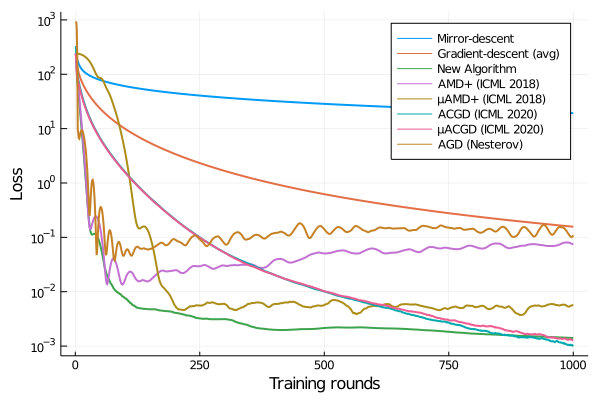

In [4]:
using Plots

fig = plot(max.(hcat(p1,p2,p3,p4,p5,p6,p7,p8),1e-8),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "μACGD (ICML 2020)" "AGD (Nesterov)"], xlabel = "Training rounds", ylabel = "Loss")

## Experiment B

In [156]:
function exact_gradient(x)
    return ∇f(x), 0
end

function noisy_gradient(x)
    n = size(x,1);
    ξ = 1; 
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

function binary(x)
    η = -∇f(x) + sign.(∇f(x)) .* (abs.(∇f(x)) .> norm(∇f(x),Inf)/2) .* norm(∇f(x),Inf)/2;
    return ∇f(x) + η, norm(η,2)
end

function random_sparsification(x)
    grad = ∇f(x)
    n = size(grad,1)
    r = 1/4;
    mask = Float64.(rand(n) .< r)
    rs_gradient = grad.*mask;
    return rs_gradient, norm(rs_gradient,2)
end

function dithering(x)
    q = Inf;
    grad = ∇f(x)
    n = size(grad,1)
    levels = 10;
    leveled_gradient = sign.(grad).*(levels/norm(grad,q)).*grad/2
    base = floor.(leveled_gradient)
    rv = Float64.(rand(n) .> (leveled_gradient .- floor.(leveled_gradient)))
    quantized_gradient = sign.(grad).*(base .+ rv)*norm(grad,q)/levels*2;
    
    return quantized_gradient, norm(quantized_gradient,2)
end

function natural_compression(x)

    grad = ∇f(x)
    n = size(grad,1)
    nat_grad = sign.(grad).*2.0.^(floor.(log2.(abs.(grad)))).*(1 .+ rand(n))
    
    return nat_grad, norm(nat_grad,2)
end

natural_compression (generic function with 1 method)

In [173]:
using LinearAlgebra

data, labels = load_libsvm_dataset("mushrooms",500); # dataset name (a5a, mushrooms), num samples
f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

k = 1000
n = size(data,2)
x_ini = zeros(n)
μ = 0.2
L = 400

ω = 0;
@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,10*k,Inf,false)[end]
grad_fun = random_sparsification
    
@time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt
@time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,false) .- f_opt;
@time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
@time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;
#@time p8 = AGD(f,grad_fun,x_ini,k) .- f_opt;

┌ Info: Loading dataset mushrooms with 500 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25


  2.203484 seconds (829.82 k allocations: 13.038 GiB, 16.79% gc time)
  0.251602 seconds (70.22 k allocations: 1.300 GiB, 15.01% gc time)
  0.247968 seconds (69.03 k allocations: 1.300 GiB, 14.70% gc time)
  0.267650 seconds (166.49 k allocations: 1.311 GiB, 12.95% gc time)
  0.249235 seconds (85.98 k allocations: 1.303 GiB, 14.81% gc time)
  0.260486 seconds (101.28 k allocations: 1.308 GiB, 11.82% gc time)
  0.245358 seconds (95.33 k allocations: 1.305 GiB, 12.52% gc time)
  0.245017 seconds (97.14 k allocations: 1.306 GiB, 13.54% gc time)


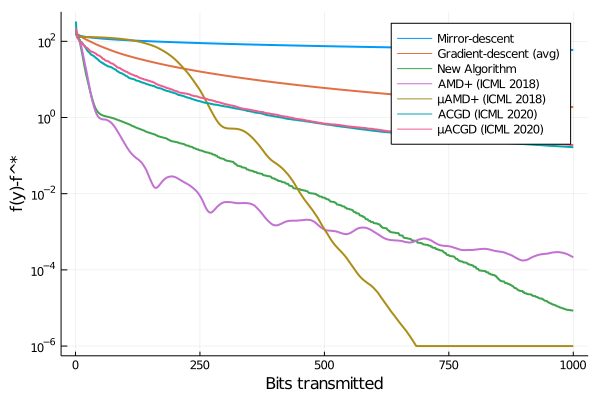

In [174]:
fig = plot(max.(min.(hcat(p1,p2,p3,p4,p5,p6,p7),1e3),1e-6),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "μACGD (ICML 2020)"], xlabel = "Bits transmitted", ylabel = "f(y)-f^*")

## Experiment C


In [76]:
using Acceleration
using LinearAlgebra

for model in ["mushrooms","a5a"]
    
    data, labels = load_libsvm_dataset(model,1000); # dataset name (a5a, mushrooms), num samples
    f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

    d,n = size(data)
    x_ini = zeros(n)
    k = 2000;
    μ = 0.1
    L = 200
    if(model=="a5a")
        L = 1000;
    end
    ω = 0;


    @time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf,false)[end]

    @time for grad_fun in [exact_gradient,random_sparsification, dithering, natural_compression]

        p3 = max.(1e-12,ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,false) .- f_opt);
        p4 = max.(1e-12,AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
        p7 = max.(1e-12,μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt);
    
        filename = string("logs/",model,"_",grad_fun,".txt")
        io = open(filename, "w")
        
        if(grad_fun==exact_gradient)
            bits = n*64;
        elseif(grad_fun==random_sparsification)
            bits = (n/4)*64;
        elseif(grad_fun==dithering)
            bits = 2.8*n + 64;
        elseif(grad_fun==natural_compression)
            bits = n*9;
        end
        
        for i=1:k
            print(io,i)
            print(io,"\t")
            print(io,i*n*64)
            print(io,"\t")
            print(io,i*bits)
            print(io,"\t")
            print(io, p7[i])
            print(io,"\t")
            print(io, p4[i])
            print(io,"\t")
            print(io, p3[i])
            print(io,"\n")
        end
        close(io)
    end
end

┌ Info: Loading dataset mushrooms with 1000 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25


  2.206109 seconds (306.99 k allocations: 10.354 GiB, 17.01% gc time)
 13.194865 seconds (1.76 M allocations: 62.154 GiB, 16.42% gc time)


┌ Info: Loading dataset a5a with 1000 samples (out ouf 6414) and 122 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25


  2.094321 seconds (306.99 k allocations: 11.253 GiB, 17.63% gc time)
 14.834331 seconds (1.76 M allocations: 67.550 GiB, 16.25% gc time)


## Experiment D

In [177]:
using LinearAlgebra

data, labels = load_dataset("MNIST",[0,1],1000,100);
f,∇f,∇ϕ_cjg,σ,L,μ  = linear_regression(data,labels);

k = 1000
n = size(data,2)
x_ini = zeros(n)

ω = 0;
@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,10*k,Inf,false)[end]
grad_fun = exact_gradient
    
@time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,false) .- f_opt;
@time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
@time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;


@time for grad_fun in [exact_gradient,noisy_gradient]

    @time p1 = max.(1e-12,MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
    @time p2 = max.(PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
    @time p3 = max.(ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,true) .- f_opt);
    @time p4 = max.(AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
    @time p5 = max.(μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt);
    @time p6 = max.(ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt);
    @time p7 = max.(μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt);

    filename = string("logs/MNIST_",grad_fun,".txt")
    io = open(filename, "w")

    for i=1:k
        print(io,i)
        print(io,"\t")
        print(io, p1[i])
        print(io,"\t")
        print(io, p2[i])
        print(io,"\t")
        print(io, p3[i])
        print(io,"\t")
        print(io, p4[i])
        print(io,"\t")
        print(io, p5[i])
        print(io,"\t")
        print(io, p6[i])
        print(io,"\t")
        print(io, p7[i])
        print(io,"\n")
    end
    close(io)
end

┌ Info: Loading dataset MNIST with 60000 samples and 784 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/datasets.jl:41


  1.504734 seconds (678.99 k allocations: 993.869 MiB, 5.12% gc time)
  0.137886 seconds (21.50 k allocations: 91.974 MiB, 2.95% gc time)
  0.122786 seconds (21.50 k allocations: 91.974 MiB, 2.77% gc time)
  0.196306 seconds (66.99 k allocations: 99.384 MiB)
  0.173856 seconds (26.50 k allocations: 94.568 MiB, 4.17% gc time)
  0.142153 seconds (34.49 k allocations: 98.888 MiB, 2.49% gc time)
  0.141694 seconds (30.50 k allocations: 96.309 MiB)
  0.134014 seconds (30.50 k allocations: 96.309 MiB, 2.47% gc time)
  0.144112 seconds (21.50 k allocations: 91.974 MiB, 2.87% gc time)
  0.135192 seconds (21.50 k allocations: 91.974 MiB)
  0.161892 seconds (84.99 k allocations: 100.498 MiB, 2.32% gc time)
  0.120782 seconds (26.50 k allocations: 94.568 MiB, 3.03% gc time)
  0.117012 seconds (34.50 k allocations: 98.888 MiB)
  0.142730 seconds (30.50 k allocations: 96.309 MiB, 2.19% gc time)
  0.139493 seconds (30.50 k allocations: 96.309 MiB, 2.24% gc time)
  0.155674 seconds (25.50 k allocatio

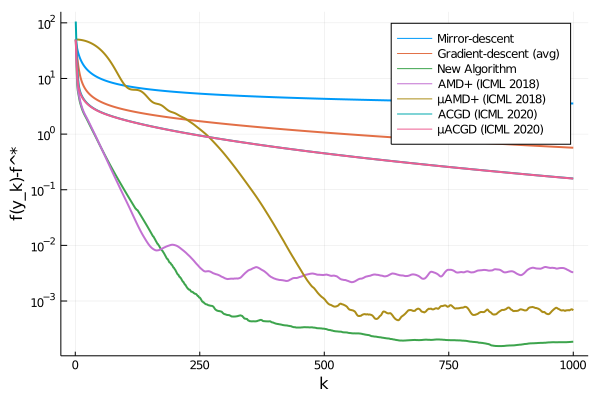

In [178]:
fig = plot(max.(min.(hcat(p1,p2,p3,p4,p5,p6,p7),1e3),1e-6),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "μACGD (ICML 2020)"], xlabel = "k", ylabel = "f(y_k)-f^*")

In [179]:
μ

4.416140701251106

In [180]:
L

8136.714053318137